In [1]:
# https://nextjournal.com/gkoehler/pytorch-mnist

In [1]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import data_gen2
import tropical

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

from sklearn.neighbors import NearestNeighbors

import math

from cvxopt import solvers, matrix

import time

from IPython.display import HTML, display
import tabulate

%matplotlib notebook
#plt.ion()

In [2]:
# Hyperparameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# Load training and testing sets
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [6]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [7]:
train_losses = []
train_acc = []
train_counter = []
test_losses = []
test_acc = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [8]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            pred = output.data.max(1, keepdim=True)[1]
            correct = pred.eq(target.data.view_as(pred)).sum()
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item(), 100. * correct / 64))
            
            train_losses.append(loss.item())
            train_acc.append(100. * correct / 64)
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [9]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))

In [10]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/ben/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3197, Accuracy: 921/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295876	Accuracy: 7.000000
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.717218	Accuracy: 85.000000
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.648279	Accuracy: 78.000000
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.780567	Accuracy: 76.000000
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.578907	Accuracy: 84.000000
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.301817	Accuracy: 92.000000
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.410833	Accuracy: 89.000000
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.130464	Accuracy: 98.000000
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.266642	Accuracy: 89.000000
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.342565	Accuracy: 89.000000

Test set: Avg. loss: 0.2731, Accuracy: 9240/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.328436	Accuracy: 87.000000
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.375078	Accuracy: 87.000000
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.368630	Accuracy:

In [11]:
# fig = plt.figure()
# plt.plot(train_counter, train_acc, color='blue')
# plt.plot(test_counter, test_acc, 'o', color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
# plt.xlabel('number of training examples seen')
# plt.ylabel('negative log likelihood loss')

In [12]:
params = []
for param in network.parameters():
    params.append(param.detach().numpy())

A1 = params[0]
b1 = params[1]
A2 = params[2][0,:].reshape((1, -1))
b2 = params[3][:1]

#Fterms, Gterms = tropical.getTropCoeffs(A1, b1, A2, b2, doTime=True)

In [14]:
Ftermsfull = []
Gtermsfull = []
for i in range(0, np.size(A1, axis = 0), 10):
    Fterms, Gterms = tropical.getTropCoeffs(A1[i:i+10, :], b1[i:i+10], A2[:, i:i+10], b2)
    Ftermsfull.append(Fterms)
    Gtermsfull.append(Gterms)

In [15]:
prodF = 1
prodG = 1
for i in range(len(Ftermsfull)):
    print(len(Ftermsfull[i]), len(Gtermsfull[i]))
    prodF *= len(Ftermsfull[i])
    prodG *= len(Gtermsfull[i])
    
print(math.log(prodF, 2), math.log(prodG, 2))

32 32
8 128
32 32
128 8
64 16
32 32
16 64
16 64
16 64
32 32
4 256
8 128
16 16
57.0 71.0


In [16]:
def multiplyTrops(trop1, trop2):
    temp = trop1 + trop2[0, :]
    for i in range(1, trop2.shape[0]):
        temp = np.vstack((temp, trop1 + trop2[i, :]))
    return temp

In [17]:
solvers.options['show_progress'] = False
def computeW(i, k, lam, gam, nbrs, temp):
    _, indices = nbrs.kneighbors(temp[i:i+1, :])
    indices = indices[0,1:]
    neighbors = temp[indices, :]

    # Set up quadratic programming problem
    Qtild = np.dot(temp[indices, :], temp[indices, :].T)
    Etild = np.eye(k)
    E = gam*np.bmat([[Etild, -Etild], [-Etild, Etild]])

    A = np.ones((2*k, 1))
    A[k:, :] = -1

    G = -np.eye(2*k)
    h = np.zeros((2*k, 1))

    b = np.array([1.0]).reshape(1,1)
    Q = np.bmat([[Qtild, -Qtild], [-Qtild, Qtild]]) + E
    
    c = np.dot(temp[indices, :], temp[i, :])
    c = c.reshape(-1, 1)
    c = np.bmat([[-c], [c]]) + lam
    
    # Solve quadratic programming problem
    out = solvers.qp(matrix(Q), matrix(c), matrix(G), matrix(h), matrix(A.T), matrix(b))
    
    # If there are negative weight values, it's near the convex hull
    w = np.array(out['x'])[:k] - np.array(out['x'])[k:]
    return w

def computeWs(points, k=1000, lam=1e-3, gam=1e-6):
    # Rescale points to roughly 0 to 1
    shift = np.amin(points)
    points = points - shift
    scale = np.amax(points)
    points = points/scale
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(points)
    goodIndices = []
    ws = np.zeros((points.shape[0], k))

    start = time.time()
    end = points.shape[0]
    for i in range(end):
        w = computeW(i, k, lam, gam, nbrs, points)
        ws[i, :] = w.T
        if np.sum(w < 0) > 0:
            goodIndices.append(i)
        if (i+1) % 100 == 0 or i+1 == end or i == 0:
            print('i = {}/{}\tverts={}\ttime={}'.format(i+1, end, len(goodIndices), time.time()-start))
            
    return ws, goodIndices

from joblib import Parallel, delayed
def computeWsParallel(points, k=1000, lam=1e-3, gam=1e-6):
    shift = np.amin(points)
    points = points - shift
    scale = np.amax(points)
    points = points/scale
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(points)
    goodIndices = []
    ws = np.zeros((points.shape[0], k))

    start = time.time()
    end = points.shape[0]
    for i in range(0, end, 100):
        wsT = Parallel(n_jobs=4)(delayed(computeW)(i, k, lam, gam, nbrs, points) for i in range(i, max(i+100, end)))
        for j in range(len(wsT)):
            ws[i, :] = wsT[j].T
            if np.sum(wsT[j] < 0) > 0:
                goodIndices.append(i + j)
            print('i = {}/{}\tverts={}\ttime={}'.format(i+j+1, end, len(goodIndices), time.time()-start))
            
    return ws, goodIndices

In [18]:
# Decrease number of samples used for each reduction to reduce memory footprint
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=16, shuffle=True)

In [19]:
def getUsedIndices(temp):
    count = set()
    for data, target in train_loader:
        train_data = data.view(-1, 28*28).numpy()
        train_data = np.hstack((train_data, np.ones((train_data.shape[0], 1))))

        count.update(np.argmax(np.matmul(temp, train_data.T).T, axis=1))
        
    return count


In [20]:
def addAndConvexHull(listOfFterms):
    newFterms2 = []
    goodIndicesFull2 = []
    for i in range(0, len(listOfFterms)-1, 2):
        start = time.time()
        tempAdd = np.array(list(listOfFterms[i]))
        tempAdd2 = np.array(list(listOfFterms[i+1]))
        temp = multiplyTrops(tempAdd, tempAdd2)

        # There may be an odd number of terms - in that case, wrap the last in with the previous 2
        #if len(listOfFterms) - 1 <= i+2:
        #    tempAdd3 = np.array(list(listOfFterms[i+2]))
        #    temp = multiplyTrops(temp, tempAdd3)

        goodIndices = getUsedIndices(temp)
        newFterms2.append(temp[list(goodIndices), :])
        goodIndicesFull2.append(goodIndices)
        print('{} * {} = {} -> {} taking {} seconds'.format(tempAdd.shape[0], tempAdd2.shape[0], tempAdd.shape[0]*tempAdd2.shape[0], len(goodIndices), time.time() - start))
    if len(listOfFterms) % 2 == 1:
        newFterms2.append(np.array(list(listOfFterms[-1])))
        goodIndicesFull2.append(np.array(list(range(np.array(list(listOfFterms[-1])).shape[0]))))
    return newFterms2, goodIndicesFull2

In [21]:
def reshuffleTerms(inputTerms):
    terms = sorted(inputTerms, key=len)
    if len(terms) % 2 == 1:
        toEnd = [terms[-1]]
        terms = terms[:-1]
    else:
        toEnd = []
    test = []
    for i in range(len(terms)//2):
        test.append(terms[i])
        test.append(terms[-i-1])
    test = test + toEnd
    return test

In [22]:
start = time.time()
newFterms2, goodIndicesFull2  = addAndConvexHull(reshuffleTerms(Ftermsfull))
    
print([val.shape[0] for val in newFterms2])
print([len(val) for val in goodIndicesFull2])

print(time.time() - start)

4 * 64 = 256 -> 253 taking 7.284416675567627 seconds
8 * 32 = 256 -> 255 taking 7.740442991256714 seconds
8 * 32 = 256 -> 241 taking 7.55243182182312 seconds
16 * 32 = 512 -> 462 taking 8.861506938934326 seconds
16 * 32 = 512 -> 423 taking 8.389479875564575 seconds
16 * 16 = 256 -> 250 taking 7.7064409255981445 seconds
[253, 255, 241, 462, 423, 250, 128]
[253, 255, 241, 462, 423, 250, 128]
47.565720558166504


In [23]:
start = time.time()

newFterms2, goodIndicesFull2  = addAndConvexHull(reshuffleTerms(newFterms2))

print([val.shape[0] for val in newFterms2])
print([len(val) for val in goodIndicesFull2])

print(time.time() - start)

128 * 423 = 54144 -> 6517 taking 292.6707401275635 seconds
241 * 255 = 61455 -> 8282 taking 308.7026569843292 seconds
250 * 253 = 63250 -> 7156 taking 315.75306010246277 seconds
[6517, 8282, 7156, 462]
[6517, 8282, 7156, 462]
917.2004611492157


In [ ]:
15# Slow and large memory footrpint

start = time.time()
newFterms2, goodIndicesFull2  = addAndConvexHull(reshuffleTerms(newFterms2))

print([val.shape[0] for val in newFterms2])
print([len(val) for val in goodIndicesFull2])

print(time.time() - start)

In [24]:
start = time.time()
newGterms2, goodIndicesFullG2  = addAndConvexHull(reshuffleTerms(Gtermsfull))
    
print([val.shape[0] for val in newGterms2])
print([len(val) for val in goodIndicesFullG2])

print(time.time() - start)

8 * 128 = 1024 -> 664 taking 9.688554048538208 seconds
16 * 128 = 2048 -> 1078 taking 14.561833143234253 seconds
16 * 64 = 1024 -> 718 taking 9.591548442840576 seconds
32 * 64 = 2048 -> 1190 taking 14.191811800003052 seconds
32 * 64 = 2048 -> 1550 taking 14.375822305679321 seconds
32 * 32 = 1024 -> 756 taking 9.64955186843872 seconds
[664, 1078, 718, 1190, 1550, 756, 256]
[664, 1078, 718, 1190, 1550, 756, 256]
72.11312460899353


In [25]:
start = time.time()

newGterms2, goodIndicesFullG2  = addAndConvexHull(reshuffleTerms(newGterms2))

print([val.shape[0] for val in newGterms2])
print([len(val) for val in goodIndicesFullG2])

print(time.time() - start)

256 * 1190 = 304640 -> 10942 taking 1963.8253242969513 seconds
664 * 1078 = 715792 -> 12301 taking 8346.098369598389 seconds
718 * 756 = 542808 -> 12328 taking 3134.967309951782 seconds
[10942, 12301, 12328, 1550]
[10942, 12301, 12328, 1550]
13445.48303771019


In [ ]:
# Slow and large memory footrpint

start = time.time()

newGterms2, goodIndicesFullG2  = addAndConvexHull(reshuffleTerms(newGterms2))

print([val.shape[0] for val in newGterms2])
print([len(val) for val in goodIndicesFullG2])

print(time.time() - start)

In [13]:
# MNIST
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1000, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1000, shuffle=True)

countF = set()
countG = set()
countT = set()
j = 0

for data, target in train_loader:
    train_data = data.view(-1, 28*28).numpy()
    #train_data = np.hstack((train_data, np.ones((train_data.shape[0], 1))))

    resF = np.matmul(A1[A2.reshape(-1) > 0, :], train_data.T).T + b1[A2.reshape(-1) > 0]
    resF = resF > 0
    resG = np.matmul(A1[A2.reshape(-1) < 0, :], train_data.T).T + b1[A2.reshape(-1) < 0]
    resG = resG > 0
    resT = np.matmul(A1, train_data.T).T + b1
    resT = resT > 0
    
    for i in range(resF.shape[0]):
        countF.add(tuple(resF[i, :]))
        countG.add(tuple(resG[i, :]))
        countT.add(tuple(resT[i, :]))
        j+=1
        
    #print(j, len(countF), len(countG), len(countT))

countFTest = set()
countGTest = set()
countTTest = set()
k = 0
for data, target in test_loader:
    train_data = data.view(-1, 28*28).numpy()
    #train_data = np.hstack((train_data, np.ones((train_data.shape[0], 1))))

    resF = np.matmul(A1[A2.reshape(-1) > 0, :], train_data.T).T + b1[A2.reshape(-1) > 0]
    resF = resF > 0
    resG = np.matmul(A1[A2.reshape(-1) < 0, :], train_data.T).T + b1[A2.reshape(-1) < 0]
    resG = resG > 0
    resT = np.matmul(A1, train_data.T).T + b1
    resT = resT > 0
    
    for i in range(resF.shape[0]):
        countFTest.add(tuple(resF[i, :]))
        countGTest.add(tuple(resG[i, :]))
        countTTest.add(tuple(resT[i, :]))
        k+=1
        
    #print(j, len(countFTest), len(countGTest), len(countTTest))
    
# print('MNIST all')
# print('total samples')
# print('train =', j, 'test =', k, 'total =', j+k)
# print('train')
# print(len(countF), len(countG), len(countT))
# print('test')
# print(len(countFTest), len(countGTest), len(countTTest))
# print('test - train')
# print(len(countFTest - countF), len(countGTest - countG), len(countTTest - countT))
# print('test union train')
# print(len(countFTest.union(countF)), len(countGTest.union(countG)), len(countGTest.union(countG)))

table = [['MNIST', 'F', 'G', 'full net', 'Samples'],
         ['Train', len(countF), len(countG), len(countT), j],
         ['Test', len(countFTest), len(countGTest), len(countTTest), k],
         ['Test - train', len(countFTest - countF), len(countGTest - countG), len(countTTest - countT), '-'],
         ['Test ∪ train', len(countFTest.union(countF)), len(countGTest.union(countG)), len(countTTest.union(countT)), j+k]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

MNIST,F,G,full net,Samples
Train,55726,57063,59911,60000
Test,9722,9824,9997,10000
Test - train,8866,9122,9967,-
Test ∪ train,64592,66185,69878,70000


In [16]:
# EMNIST digits
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.EMNIST('files/', 'digits', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1000, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.EMNIST('files/', 'digits', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1000, shuffle=True)

countF = set()
countG = set()
countT = set()
j = 0

for data, target in train_loader:
    train_data = data.view(-1, 28*28).numpy()
    #train_data = np.hstack((train_data, np.ones((train_data.shape[0], 1))))

    resF = np.matmul(A1[A2.reshape(-1) > 0, :], train_data.T).T + b1[A2.reshape(-1) > 0]
    resF = resF > 0
    resG = np.matmul(A1[A2.reshape(-1) < 0, :], train_data.T).T + b1[A2.reshape(-1) < 0]
    resG = resG > 0
    resT = np.matmul(A1, train_data.T).T + b1
    resT = resT > 0
    
    for i in range(resF.shape[0]):
        countF.add(tuple(resF[i, :]))
        countG.add(tuple(resG[i, :]))
        countT.add(tuple(resT[i, :]))
        j+=1
        
    #print(j, len(countF), len(countG), len(countT))

countFTest = set()
countGTest = set()
countTTest = set()
k = 0
for data, target in test_loader:
    train_data = data.view(-1, 28*28).numpy()
    #train_data = np.hstack((train_data, np.ones((train_data.shape[0], 1))))

    resF = np.matmul(A1[A2.reshape(-1) > 0, :], train_data.T).T + b1[A2.reshape(-1) > 0]
    resF = resF > 0
    resG = np.matmul(A1[A2.reshape(-1) < 0, :], train_data.T).T + b1[A2.reshape(-1) < 0]
    resG = resG > 0
    resT = np.matmul(A1, train_data.T).T + b1
    resT = resT > 0
    
    for i in range(resF.shape[0]):
        countFTest.add(tuple(resF[i, :]))
        countGTest.add(tuple(resG[i, :]))
        countTTest.add(tuple(resT[i, :]))
        k+=1
        
    #print(j, len(countFTest), len(countGTest), len(countTTest))
    
# print('EMNIST digits')
# print('total samples')
# print('train =', j, 'test =', k, 'total =', j+k)
# print('train')
# print(len(countF), len(countG), len(countT))
# print('test')
# print(len(countFTest), len(countGTest), len(countTTest))
# print('test - train')
# print(len(countFTest - countF), len(countGTest - countG), len(countTTest - countT))
# print('test union train')
# print(len(countFTest.union(countF)), len(countGTest.union(countG)), len(countGTest.union(countG)))

table = [['EMNIST digits', 'F', 'G', 'full net', 'Samples'],
         ['Train', len(countF), len(countG), len(countT), j],
         ['Test', len(countFTest), len(countGTest), len(countTTest), k],
         ['Test - train', len(countFTest - countF), len(countGTest - countG), len(countTTest - countT), '-'],
         ['Test ∪ train', len(countFTest.union(countF)), len(countGTest.union(countG)), len(countTTest.union(countT)), j+k]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

EMNIST digits,F,G,full net,Samples
Train,207393,220584,238222,240000
Test,37624,38619,39929,40000
Test - train,32194,35168,39485,-
Test ∪ train,239587,255752,277707,280000


In [15]:
# EMNIST digits and characters
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.EMNIST('files/', 'byclass', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1000, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.EMNIST('files/', 'byclass', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1000, shuffle=True)

countF = set()
countG = set()
countT = set()
j = 0

for data, target in train_loader:
    train_data = data.view(-1, 28*28).numpy()
    #train_data = np.hstack((train_data, np.ones((train_data.shape[0], 1))))

    resF = np.matmul(A1[A2.reshape(-1) > 0, :], train_data.T).T + b1[A2.reshape(-1) > 0]
    resF = resF > 0
    resG = np.matmul(A1[A2.reshape(-1) < 0, :], train_data.T).T + b1[A2.reshape(-1) < 0]
    resG = resG > 0
    resT = np.matmul(A1, train_data.T).T + b1
    resT = resT > 0
    
    for i in range(resF.shape[0]):
        countF.add(tuple(resF[i, :]))
        countG.add(tuple(resG[i, :]))
        countT.add(tuple(resT[i, :]))
        j+=1
        
    #print(j, len(countF), len(countG), len(countT))

countFTest = set()
countGTest = set()
countTTest = set()
k = 0
for data, target in test_loader:
    train_data = data.view(-1, 28*28).numpy()
    #train_data = np.hstack((train_data, np.ones((train_data.shape[0], 1))))

    resF = np.matmul(A1[A2.reshape(-1) > 0, :], train_data.T).T + b1[A2.reshape(-1) > 0]
    resF = resF > 0
    resG = np.matmul(A1[A2.reshape(-1) < 0, :], train_data.T).T + b1[A2.reshape(-1) < 0]
    resG = resG > 0
    resT = np.matmul(A1, train_data.T).T + b1
    resT = resT > 0
    
    for i in range(resF.shape[0]):
        countFTest.add(tuple(resF[i, :]))
        countGTest.add(tuple(resG[i, :]))
        countTTest.add(tuple(resT[i, :]))
        k+=1
        
    #print(j, len(countFTest), len(countGTest), len(countTTest))
    
# print('EMNIST all')
# print('total samples')
# print('train =', j, 'test =', k, 'total =', j+k)
# print('train')
# print(len(countF), len(countG), len(countT))
# print('test')
# print(len(countFTest), len(countGTest), len(countTTest))
# print('test - train')
# print(len(countFTest - countF), len(countGTest - countG), len(countTTest - countT))
# print('test union train')
# print(len(countFTest.union(countF)), len(countGTest.union(countG)), len(countGTest.union(countG)))

table = [['EMNIST all', 'F', 'G', 'full net', 'Samples'],
         ['Train', len(countF), len(countG), len(countT), j],
         ['Test', len(countFTest), len(countGTest), len(countTTest), k],
         ['Test - train', len(countFTest - countF), len(countGTest - countG), len(countTTest - countT), '-'],
         ['Test ∪ train', len(countFTest.union(countF)), len(countGTest.union(countG)), len(countTTest.union(countT)), j+k]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

EMNIST all,F,G,full net,Samples
Train,593786,630656,690066,697932
Test,107791,110862,115910,116323
Test - train,92212,100526,114149,-
Test ∪ train,685998,731182,804215,814255


time =  302.196284532547


Random,F,G,full net,samples
,2820669,6822806,9999514,10000000


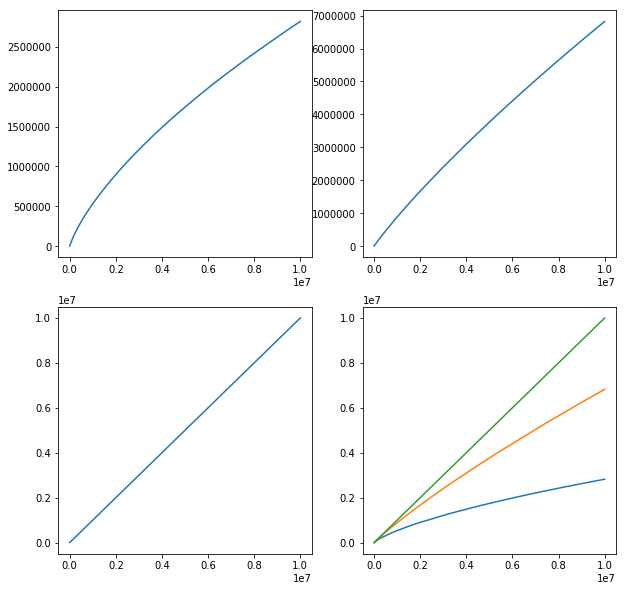

In [13]:
# Random samples
countF = set()
countG = set()
countT = set()
j = 0
start = time.time()

valsF = []
valsG = []
valsT = []
iters = []

for sample in range(10000):
    train_data = (np.random.uniform(0, 1, (1000, 28*28)) - 0.1307)/0.3081
    #train_data = np.hstack((train_data, np.ones((train_data.shape[0], 1))))

    resF = np.matmul(A1[A2.reshape(-1) > 0, :], train_data.T).T + b1[A2.reshape(-1) > 0]
    resF = resF > 0
    resG = np.matmul(A1[A2.reshape(-1) < 0, :], train_data.T).T + b1[A2.reshape(-1) < 0]
    resG = resG > 0
    resT = np.matmul(A1, train_data.T).T + b1
    resT = resT > 0
    
    for i in range(resF.shape[0]):
        countF.add(np.packbits(resF[i, :]).tostring())
        countG.add(np.packbits(resG[i, :]).tostring())
        countT.add(np.packbits(resT[i, :]).tostring())
        j+=1
        
    valsF.append(len(countF))
    valsG.append(len(countG))
    valsT.append(len(countT))
    iters.append(j)
        
print('time = ', time.time()-start)
# print('total samples')
# print(j,)
# print('train')
# print(len(countF), len(countG), len(countT))

table = [['Random', 'F', 'G', 'full net', 'samples'],
         ['', len(countF), len(countG), len(countT), j]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

fig = plt.figure(figsize=(10,10))
axF = fig.add_subplot(221)
axG = fig.add_subplot(222)
axT = fig.add_subplot(223)
axAll = fig.add_subplot(224)

axF.plot(iters, valsF)
axG.plot(iters, valsG)
axT.plot(iters, valsT)

axAll.plot(iters, valsF)
axAll.plot(iters, valsG)
axAll.plot(iters, valsT)

In [32]:
import sys
print(sys.getsizeof(resT[i, :]))
print(sys.getsizeof(tuple(resT[i, :])))
print(sys.getsizeof(np.packbits(resT[i, :])))
print(sys.getsizeof(resT[i, :].tostring()))
print(sys.getsizeof(np.packbits(resF[i, :]).tostring()))

96
1072
112
161
41


time =  5316.909109830856


Random,F,G,full net,samples
,12348200,43147001,99950187,100000000


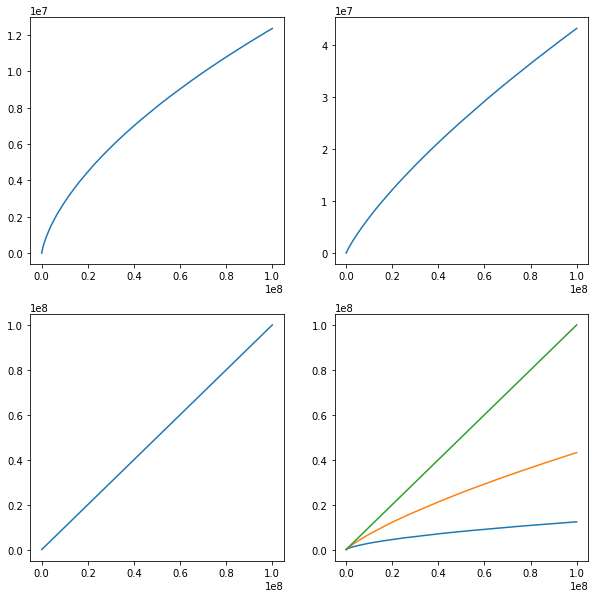

In [13]:
# Random samples
countF = set()
countG = set()
countT = set()
j = 0
start = time.time()

valsF = []
valsG = []
valsT = []
iters = []

for sample in range(100000):
    train_data = (np.random.uniform(0, 1, (1000, 28*28)) - 0.1307)/0.3081
    #train_data = np.hstack((train_data, np.ones((train_data.shape[0], 1))))

    resF = np.matmul(A1[A2.reshape(-1) > 0, :], train_data.T).T + b1[A2.reshape(-1) > 0]
    resF = resF > 0
    resG = np.matmul(A1[A2.reshape(-1) < 0, :], train_data.T).T + b1[A2.reshape(-1) < 0]
    resG = resG > 0
    resT = np.matmul(A1, train_data.T).T + b1
    resT = resT > 0
    
    for i in range(resF.shape[0]):
        countF.add(np.packbits(resF[i, :]).tostring())
        countG.add(np.packbits(resG[i, :]).tostring())
        countT.add(np.packbits(resT[i, :]).tostring())
        j+=1
        
    valsF.append(len(countF))
    valsG.append(len(countG))
    valsT.append(len(countT))
    iters.append(j)
        
print('time = ', time.time()-start)
# print('total samples')
# print(j,)
# print('train')
# print(len(countF), len(countG), len(countT))

table = [['Random', 'F', 'G', 'full net', 'samples'],
         ['', len(countF), len(countG), len(countT), j]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

fig = plt.figure(figsize=(10,10))
axF = fig.add_subplot(221)
axG = fig.add_subplot(222)
axT = fig.add_subplot(223)
axAll = fig.add_subplot(224)

axF.plot(iters, valsF)
axG.plot(iters, valsG)
axT.plot(iters, valsT)

axAll.plot(iters, valsF)
axAll.plot(iters, valsG)
axAll.plot(iters, valsT)